In [1]:
import re
import os
import mgwr
import urllib
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import sklearn
import libpysal as lps

from shapely.geometry import Point
from fiona.crs import from_epsg
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from matplotlib.colors import ListedColormap
from requests import get
from urllib.parse import urlparse
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [2]:
w_path = os.path.join('london_msoa.gpkg')
if not os.path.exists(w_path):
    df_msoa = gpd.read_file('https://github.com/yiminf5/i2p_EB/raw/main/londonward.gpkg')
    df_msoa.to_file(w_path)
    print("Downloaded Ward gpkg.")
else:
    df_msoa = gpd.read_file(w_path)
    
df_msoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MSOA_CODE  983 non-null    object  
 1   MSOA_NAME  983 non-null    object  
 2   LA_CODE    983 non-null    object  
 3   LA_NAME    983 non-null    object  
 4   GEOEAST    983 non-null    int64   
 5   GEONORTH   983 non-null    int64   
 6   POPEAST    983 non-null    int64   
 7   POPNORTH   983 non-null    int64   
 8   AREA_KM2   983 non-null    float64 
 9   geometry   983 non-null    geometry
dtypes: float64(1), geometry(1), int64(4), object(4)
memory usage: 76.9+ KB


In [3]:
df_msoa.drop(columns=['LA_CODE', 'LA_NAME','GEOEAST','GEONORTH','POPEAST', 'POPNORTH', 'AREA_KM2'], inplace=True)

print(f"Data frame for msoa is {df_msoa.shape[0]:,} x {df_msoa.shape[1]}")
print(list(df_msoa.columns.values))

df_msoa = df_msoa.to_crs(epsg=27700)


Data frame for msoa is 983 x 3
['MSOA_CODE', 'MSOA_NAME', 'geometry']


In [4]:
# Load nutrition data
colsA = ['area_id','energy_tot', 'h_nutrients_calories_norm','representativeness_norm']

df_tesco_msoa = pd.read_csv('year_msoa_grocery.csv', encoding='utf-8', header=0, usecols=colsA)
    
    
print(f"Data frame for tesco is {df_tesco_msoa.shape[0]:,} x {df_tesco_msoa.shape[1]}")

Data frame for tesco is 983 x 4


In [5]:
df_tesco_msoa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_id                    983 non-null    object 
 1   energy_tot                 983 non-null    float64
 2   h_nutrients_calories_norm  983 non-null    float64
 3   representativeness_norm    983 non-null    float64
dtypes: float64(3), object(1)
memory usage: 30.8+ KB


In [6]:
indexNames = df_tesco_msoa[df_tesco_msoa['representativeness_norm'] < 0.1 ].index
df_tesco_msoa.drop(indexNames , inplace=True)

In [7]:
df_tesco_msoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 982
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_id                    886 non-null    object 
 1   energy_tot                 886 non-null    float64
 2   h_nutrients_calories_norm  886 non-null    float64
 3   representativeness_norm    886 non-null    float64
dtypes: float64(3), object(1)
memory usage: 34.6+ KB


In [10]:
df_tesco_msoa.head(10)
df_tesco_msoa.to_csv('886_diet.csv')

In [14]:
df_tesco_msoa.dropna(inplace=True)
df_tesco_msoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 982
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_id                    886 non-null    object 
 1   energy_tot                 886 non-null    float64
 2   h_nutrients_calories_norm  886 non-null    float64
 3   representativeness_norm    886 non-null    float64
dtypes: float64(3), object(1)
memory usage: 34.6+ KB


In [15]:
 # Load health data
df_adult_obesity_msoa = pd.read_csv('msoa_adult_obesity_06.csv', encoding='utf-8', header=0).dropna()
    
print(f"Data frame for adult obesity is {df_adult_obesity_msoa.shape[0]:,} x {df_adult_obesity_msoa.shape[1]}")

Data frame for adult obesity is 983 x 3


In [16]:
df_adult_obesity_msoa['Obesity2006_2008']=df_adult_obesity_msoa['Obesity2006_2008'].div(100)
df_adult_obesity_msoa.head(3)

,area_id,MSOA_Name,Obesity2006_2008
0,E02000001,City of London 001,0.137
1,E02000002,Barking and Dagenham 001,0.298
2,E02000003,Barking and Dagenham 002,0.283


In [17]:
df_adult_obesity_msoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area_id           983 non-null    object 
 1   MSOA_Name         983 non-null    object 
 2   Obesity2006_2008  983 non-null    float64
dtypes: float64(1), object(2)
memory usage: 30.7+ KB


In [19]:
df_adult_obesity_msoa.dropna(inplace=True)
df_adult_obesity_msoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area_id           983 non-null    object 
 1   MSOA_Name         983 non-null    object 
 2   Obesity2006_2008  983 non-null    float64
dtypes: float64(1), object(2)
memory usage: 30.7+ KB


In [20]:
df_join = df_tesco_msoa.merge(df_adult_obesity_msoa, left_on='area_id', right_on='area_id', how='inner')
df_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 885
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_id                    886 non-null    object 
 1   energy_tot                 886 non-null    float64
 2   h_nutrients_calories_norm  886 non-null    float64
 3   representativeness_norm    886 non-null    float64
 4   MSOA_Name                  886 non-null    object 
 5   Obesity2006_2008           886 non-null    float64
dtypes: float64(4), object(2)
memory usage: 48.5+ KB


In [21]:
df_join.head(3)

,area_id,energy_tot,h_nutrients_calories_norm,representativeness_norm,MSOA_Name,Obesity2006_2008
0,E02000001,165.856519,0.696915,0.688132,City of London 001,0.137
1,E02000002,184.372470,0.663010,0.122214,Barking and Dagenham 001,0.298
2,E02000003,195.777469,0.654252,0.186877,Barking and Dagenham 002,0.283


In [23]:
df_join.to_csv('886_join.csv')

In [24]:
df_join.describe()

,energy_tot,h_nutrients_calories_norm,representativeness_norm,Obesity2006_2008
count,886.000000,886.000000,886.000000,886.000000
mean,179.776207,0.675764,0.340789,0.208365
std,7.889516,0.011215,0.167822,0.051113
min,136.770265,0.630720,0.101303,0.098000
25%,174.823523,0.668444,0.202977,0.169000
50%,179.639173,0.676106,0.314855,0.210000
75%,184.489890,0.683932,0.447232,0.249750
max,210.496616,0.707776,1.000000,0.339000


In [11]:
wl = pd.merge(df_msoa,df_tesco_msoa, left_on='MSOA_CODE',right_on = 'area_id',how = 'left')
wlg = pd.merge(wl,df_adult_obesity_msoa, left_on='area_id',right_on = 'area_id',how = 'left')


wlg = wlg.set_index('MSOA_CODE')
wlg.head(3)

,MSOA_NAME,geometry,area_id,energy_tot,h_nutrients_calories_norm,representativeness_norm,MSOA_Name,Obesity2006_2008
MSOA_CODE,,,,,,,,
E02000001,City of London 001,"MULTIPOLYGON (((532946.061 181894.832, 532946....",E02000001,165.856519,0.696915,0.688132,City of London 001,0.137
E02000002,Barking and Dagenham 001,"MULTIPOLYGON (((548877.688 191097.328, 548877....",E02000002,184.372470,0.663010,0.122214,Barking and Dagenham 001,0.298
E02000003,Barking and Dagenham 002,"MULTIPOLYGON (((548954.499 189063.200, 548889....",E02000003,195.777469,0.654252,0.186877,Barking and Dagenham 002,0.283


In [12]:
wlg.drop(columns=['area_id','MSOA_NAME','MSOA_Name'], inplace=True)

(500648.62506375514, 564876.9056878006, 153596.6426736141, 203188.04728170787)

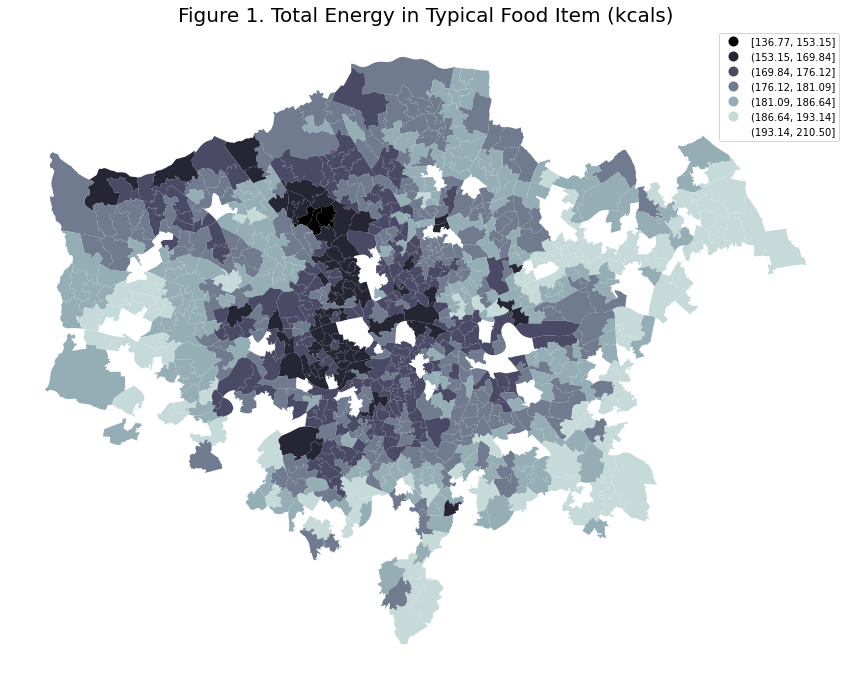

In [13]:
#plot
wlg.plot(column='energy_tot', cmap='viridis', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(15,12),
        );

plt.title("Figure 1. Total Energy in Typical Food Item (kcals)", fontsize=20)

plt.axis('off')

(500648.62506375514, 564876.9056878006, 153596.6426736141, 203188.04728170787)

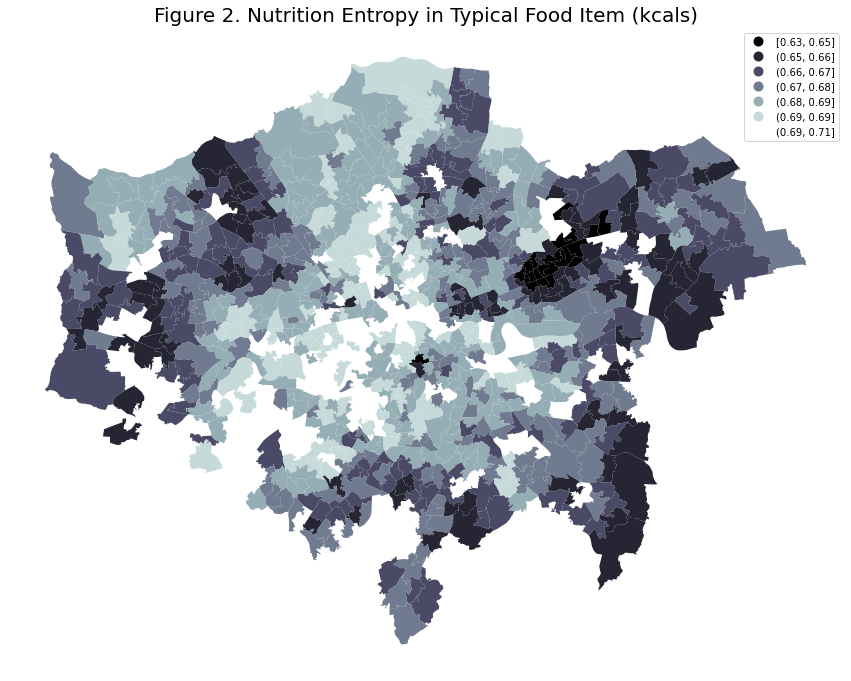

In [14]:
#plot
wlg.plot(column='h_nutrients_calories_norm', cmap='viridis', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(15,12),
        );

plt.title("Figure 2. Nutrition Entropy in Typical Food Item (kcals)", fontsize=20)

plt.axis('off')

(500648.62506375514, 564876.9056878006, 153596.6426736141, 203188.04728170787)

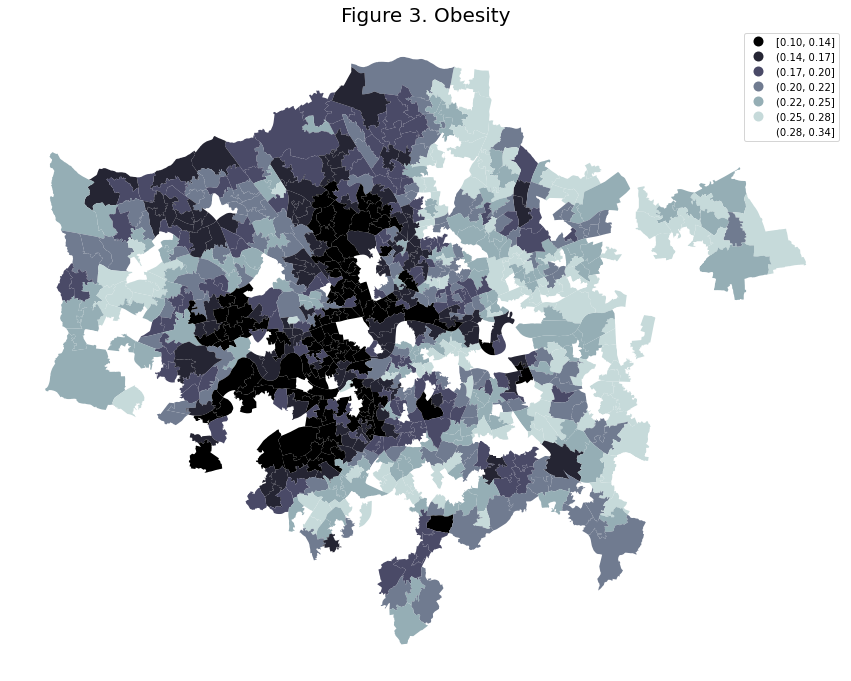

In [15]:
#plot
wlg.plot(column='Obesity2006_2008', cmap='viridis', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(15,12),
        );

plt.title("Figure 3. Obesity", fontsize=20)

plt.axis('off')

(500648.62506375514, 564876.9056878006, 153596.6426736141, 203188.04728170787)

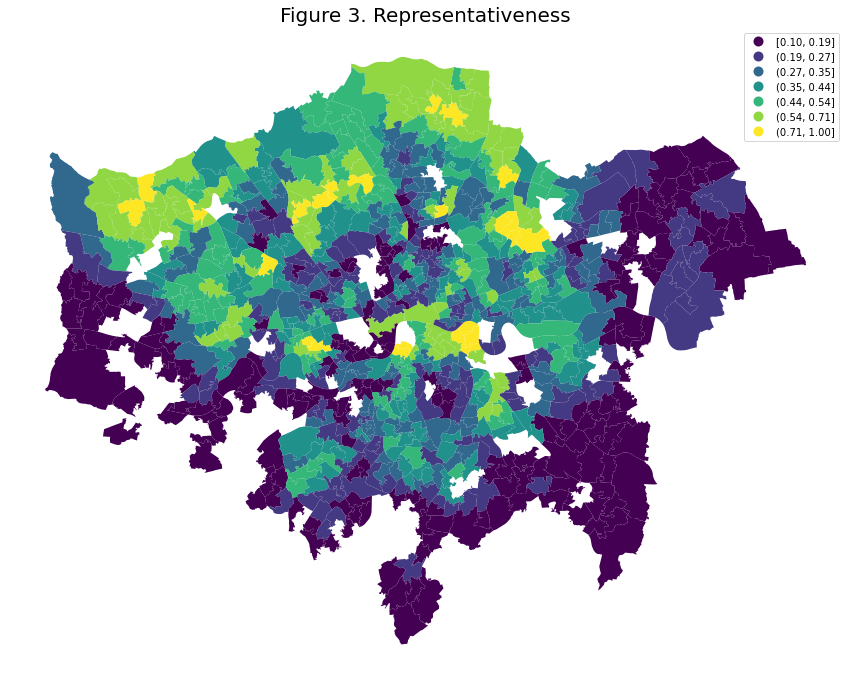

In [17]:
#plot
wlg.plot(column='representativeness_norm', cmap='viridis', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(15,12),
        );

plt.title("Figure 4. Representativeness", fontsize=20)

plt.axis('off')